In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gym
import pickle
env = gym.make('CartPole-v0')


[2017-05-19 12:34:47,498] Making new env: CartPole-v0


# Cartpole Information
- **Cartpole Source**: https://github.com/openai/gym/blob/874b6fe2afe5b241c18a973979e4094948116db1/gym/envs/classic_control/cartpole.py
- Reward is always 1 for each step

# Helper Functions

In [3]:
def histogram(l, title=""):
    plt.hist(l, bins=20)
    ax = plt.axes()
    ax.set_title(title)
    plt.show()

def histograms(values_list, title_list, width=2):
    assert(len(values_list) == len(title_list))
    
    n_rows = (len(values_list) + width - 1) / width
    f, (axs) = plt.subplots(n_rows, width)
    
    for ax, values, title in zip(axs, values_list, title_list):
        ax.hist(values, bins=20)
        ax.set_title(title)
        
    plt.show()

def tryPolicy(env, policy_fn, observationToStateFn=lambda x:x, n_episodes=20, max_episode_len=100):
    returns = []
    episode_lengths = []
    
    for i_episode in range(n_episodes):
        observation = env.reset()
        episode_len = max_episode_len
        reward_sum = 0
        for t in range(episode_len):
            state = observationToStateFn(observation)
            action_probs = policy_fn(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            observation, reward, done, info = env.step(action)
            reward_sum += reward
            if done:
                episode_len = t+1
                break
        episode_lengths.append(episode_len)
        returns.append(reward_sum)
    return returns, episode_lengths

def pickleSave(var, file_path):
    # known errors:
    # - defaultdict doesn't work when it uses lambda functions
    # - defaultdict can give strange errors; save dict(varr) instead
    # - "import reinforcement_learning as rl" syntax (use "from ... import ..." instead)
    if not file_path.endswith('.p'):
        file_path += '.p'
    pickle.dump(var, open(file_path, "wb"))
    
def pickleLoad(file_path):
    if not file_path.endswith('.p'):
        file_path += '.p'
    return pickle.load(open(file_path, "rb"))


# Action Space Format: Discrete Object
- **Discrete source code**: https://github.com/openai/gym/blob/312c8b439c5d164c08e111c99ccd2ba8cf3a5857/gym/spaces/discrete.py
- **Instance Variables**: n
- **Methods**: sample, contains, repr, eq

To take a selected step, enter an integer (eg. env.step(0))

In [4]:
print env.action_space
print "n:", env.action_space.n

Discrete(2)
n: 2


# Observation Space Format: Box Object
- **Box Source**: https://github.com/openai/gym/blob/312c8b439c5d164c08e111c99ccd2ba8cf3a5857/gym/spaces/box.py
- **Instance Variables**: low, high
- **Methods**: sample, contains, to_jsonable, from_jsonable, shape, repr, eq

In [5]:
print env.observation_space
print "low:", env.observation_space.low
print "high:", env.observation_space.high

Box(4,)
low: [ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]
high: [  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]


# Observation Format
- Array of 4 floats
- [position of cart, velocity of cart, angle of pole, rotation rate of pole]

## Sample Observation Space

In [6]:
observation_sample = []
episode_len_sample = []
for i_episode in range(20):
    observation = env.reset()
    episode_len = 100
    for t in range(episode_len):
        #env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        observation_sample.append(list(observation))
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            episode_len = t+1
            break
    episode_len_sample.append(episode_len)
observation_sample = np.array(observation_sample)

[ 0.01903209  0.00099371  0.01268536 -0.03501358]
[ 0.01905197 -0.19430783  0.01198509  0.26164457]
[ 0.01516581  0.00064101  0.01721798 -0.02723415]
[ 0.01517863  0.19551186  0.0166733  -0.31443527]
[ 0.01908887  0.00015642  0.0103846  -0.01654111]
[ 0.019092    0.19512791  0.01005377 -0.30592957]
[ 0.02299456  0.39010516  0.00393518 -0.59542491]
[ 0.03079666  0.58517182 -0.00797332 -0.88686568]
[ 0.04250009  0.78040109 -0.02571063 -1.18204441]
[ 0.05810812  0.97584711 -0.04935152 -1.48267464]
[ 0.07762506  1.17153504 -0.07900501 -1.7903526 ]
[ 0.10105576  1.36744923 -0.11481206 -2.10651055]
[ 0.12840474  1.17364958 -0.15694227 -1.85140557]
[ 0.15187774  0.98056409 -0.19397039 -1.61128878]
Episode finished after 14 timesteps
[-0.01658712 -0.00440241 -0.03075959  0.04638122]
[-0.01667517 -0.19907009 -0.02983196  0.32920273]
[-0.02065657 -0.39375494 -0.02324791  0.61233077]
[-0.02853167 -0.58854441 -0.01100129  0.89760175]
[-0.04030256 -0.78351552  0.00695074  1.1868064 ]
[-0.05597287 -

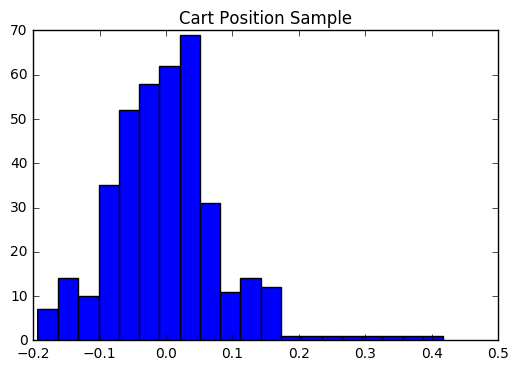

In [7]:
histogram(observation_sample[:,0], "Cart Position Sample")

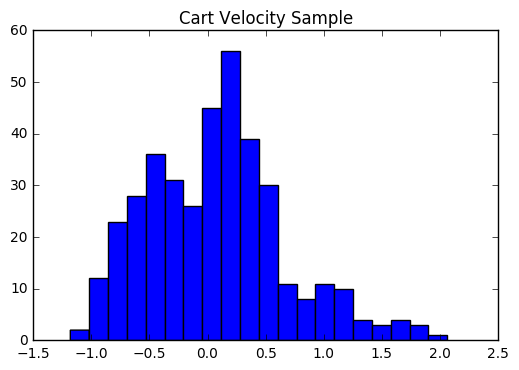

In [8]:
histogram(observation_sample[:,1], "Cart Velocity Sample")

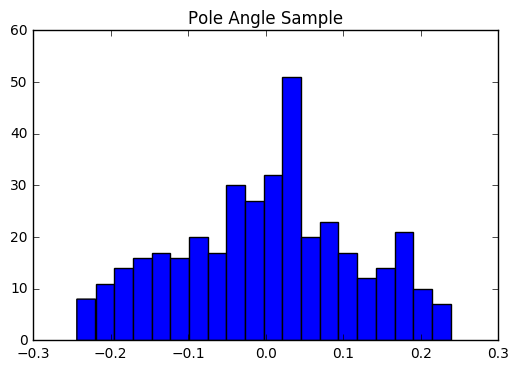

In [9]:
histogram(observation_sample[:,2], "Pole Angle Sample")

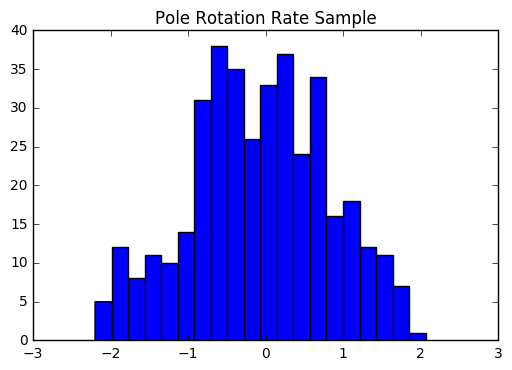

In [10]:
histogram(observation_sample[:,3], "Pole Rotation Rate Sample")

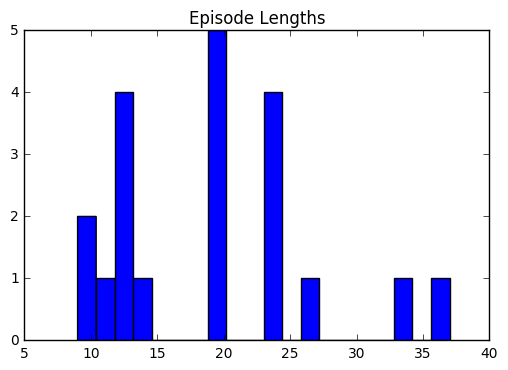

In [11]:
histogram(episode_len_sample, "Episode Lengths")

# Construct State Space for Algorithm

Cartpole has a continuous state space, so we use bins to divide the observation space into a finite set of states for our algorithm.

In [6]:
n_bins = 22
n_states = n_bins ** 4
observation_bound = np.array([4.8, 2.0, 0.4, 3.0])
observation_bin_gaps = observation_bound / ((n_bins / 2) - 1)
def observationToState(observation):
    # Pole Position: [-4.8, 4.8]
    # Pole Velocity: [-2, 2]
    # Pole Angle: [-0.4, 0.4]
    # Pole Rotation Rate: [-3, 3]
    result = 0
    for i, val in enumerate(observation):
        bound = observation_bound[i]
        bin_gap = observation_bin_gaps[i]
        result *= n_bins
        if val < -bound:
            bin_index = 0
        elif val >= bound:
            bin_index = n_bins - 1
        else:
            bin_index = 1 + int((val + bound) / bin_gap)
        
        result += bin_index
        
    return result

print "Test that bins are working for the cart position"
for i, point in enumerate(np.linspace(-4.8, 4.8, num=n_bins - 1)):
    # (0.0001 is added due to floating point errors)
    state = observationToState([point + 0.0001, -100, -100, -100])
    expected_state = (i+1) * (n_bins ** 3)
    #print state, expected_state
    assert state == expected_state
    
assert(observationToState([-100] * 4) == 0)
print "Test passed"

Test that bins are working for the cart position
Test passed


# Reinforcement Learning using Monte Carlo

In [31]:
from reinforcement_learning import mcControlEpsilonGreedy, makeQDefaultDictFn

Q, policy = mcControlEpsilonGreedy(
    env, observationToState=observationToState, num_episodes=10000, epsilon=0.1)


Episode 1000/10000.
Episode 2000/10000.
Episode 3000/10000.
Episode 4000/10000.
Episode 5000/10000.
Episode 6000/10000.
Episode 7000/10000.
Episode 8000/10000.
Episode 9000/10000.
Episode 10000/10000.


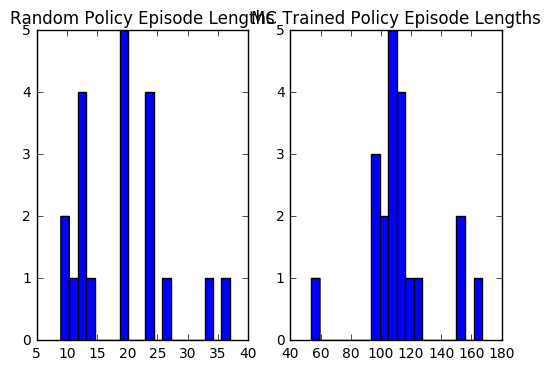

In [32]:
returns, episode_lengths = tryPolicy(
    env, policy, observationToState, n_episodes=20, max_episode_len=300)

histograms(
    [episode_len_sample, episode_lengths], 
    ["Random Policy Episode Lengths", "MC Trained Policy Episode Lengths"]
)

# Load best_q from Previous Save

In [33]:
#pickleSave(dict(Q), 'best_Q')
best_q_dict = pickleLoad('best_Q')
Q = defaultdict(makeQDefaultDictFn(env), best_q_dict)

In [37]:
Q, policy = mcControlEpsilonGreedy(
    env, default_Q=Q, observationToState=observationToState, num_episodes=100000, epsilon=0.1)

Episode 100000/500000.


In [38]:
pickleSave(dict(Q), 'best_Q')


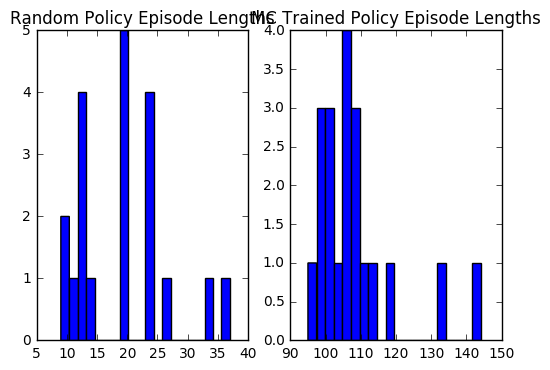

In [39]:
returns, episode_lengths = tryPolicy(
    env, policy, observationToState, n_episodes=20, max_episode_len=300)
histograms(
    [episode_len_sample, episode_lengths], 
    ["Random Policy Episode Lengths", "MC Trained Policy Episode Lengths"]
)

# Try Exploration Initialization
Initialize Q values to be very high to encourage exploration

In [50]:
def makeExploringDefaultDictFn(env):
    def exploringDefaultDictFn():
        return np.ones(env.action_space.n) * 200
    return exploringDefaultDictFn

In [51]:
Q = defaultdict(makeExploringDefaultDictFn(env))
Q, policy = mcControlEpsilonGreedy(
    env, default_Q=Q, observationToState=observationToState, num_episodes=10000, epsilon=0.1)

Episode 1000/10000.
Episode 2000/10000.
Episode 3000/10000.
Episode 4000/10000.
Episode 5000/10000.
Episode 6000/10000.
Episode 7000/10000.
Episode 8000/10000.
Episode 9000/10000.
Episode 10000/10000.


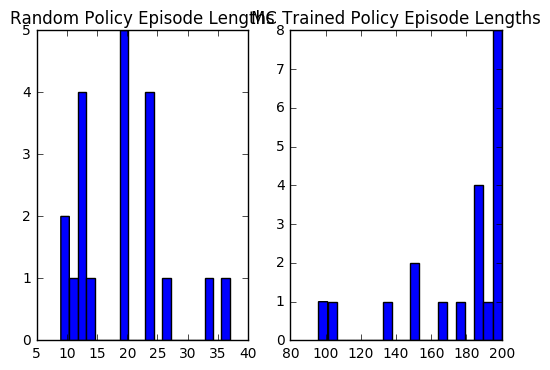

In [52]:
returns, episode_lengths = tryPolicy(
    env, policy, observationToState, n_episodes=20, max_episode_len=300)
histograms(
    [episode_len_sample, episode_lengths], 
    ["Random Policy Episode Lengths", "MC Trained Policy Episode Lengths"]
)

# Load Explore Model

In [54]:
#pickleSave(dict(Q), 'best_Q_explore')
best_q_explore_dict = pickleLoad('best_Q_explore')
Q = defaultdict(makeExploringDefaultDictFn(env), best_q_explore_dict)

In [57]:
Q, policy = mcControlEpsilonGreedy(
    env, default_Q=Q, observationToState=observationToState, num_episodes=100000, epsilon=0.1)

Episode 1000/100000.
Episode 2000/100000.
Episode 3000/100000.
Episode 4000/100000.
Episode 5000/100000.
Episode 6000/100000.
Episode 7000/100000.
Episode 8000/100000.
Episode 9000/100000.
Episode 10000/100000.
Episode 11000/100000.
Episode 12000/100000.
Episode 13000/100000.
Episode 14000/100000.
Episode 15000/100000.
Episode 16000/100000.
Episode 17000/100000.
Episode 18000/100000.
Episode 19000/100000.
Episode 20000/100000.
Episode 21000/100000.
Episode 22000/100000.
Episode 23000/100000.
Episode 24000/100000.
Episode 25000/100000.
Episode 26000/100000.
Episode 27000/100000.
Episode 28000/100000.
Episode 29000/100000.
Episode 30000/100000.
Episode 31000/100000.
Episode 32000/100000.
Episode 33000/100000.
Episode 34000/100000.
Episode 35000/100000.
Episode 36000/100000.
Episode 37000/100000.
Episode 38000/100000.
Episode 39000/100000.
Episode 40000/100000.
Episode 41000/100000.
Episode 42000/100000.
Episode 43000/100000.
Episode 44000/100000.
Episode 45000/100000.
Episode 46000/10000

In [59]:
pickleSave(dict(Q), 'best_Q_explore')

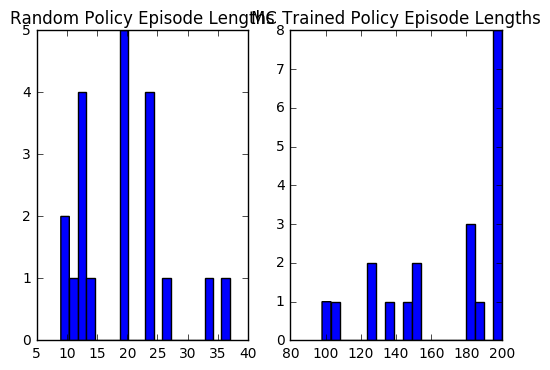

In [58]:
returns, episode_lengths = tryPolicy(
    env, policy, observationToState, n_episodes=100, max_episode_len=300)
histograms(
    [episode_len_sample, episode_lengths], 
    ["Random Policy Episode Lengths", "MC Trained Policy Episode Lengths"]
)

# Try Q Learning With Exploration

In [20]:
from reinforcement_learning import qLearning

def makeExploringDefaultDictFn(env):
    def exploringDefaultDictFn():
        return np.ones(env.action_space.n) * 50
    return exploringDefaultDictFn

#Q = defaultdict(makeExploringDefaultDictFn(env))
Q = qLearning(
    env, num_episodes=10000, observationToState=observationToState, default_Q=Q, epsilon=0.1, alpha=0.5)
Q = qLearning(
    env, num_episodes=20000, observationToState=observationToState, default_Q=Q, epsilon=0.05, alpha=0.25)
Q = qLearning(
    env, num_episodes=20000, observationToState=observationToState, default_Q=Q, epsilon=0.02, alpha=0.1)

Episode 100/10000.
Episode 200/10000.
Episode 300/10000.
Episode 400/10000.
Episode 500/10000.
Episode 600/10000.
Episode 700/10000.
Episode 800/10000.
Episode 900/10000.
Episode 1000/10000.
Episode 1100/10000.
Episode 1200/10000.
Episode 1300/10000.
Episode 1400/10000.
Episode 1500/10000.
Episode 1600/10000.
Episode 1700/10000.
Episode 1800/10000.
Episode 1900/10000.
Episode 2000/10000.
Episode 2100/10000.
Episode 2200/10000.
Episode 2300/10000.
Episode 2400/10000.
Episode 2500/10000.
Episode 2600/10000.
Episode 2700/10000.
Episode 2800/10000.
Episode 2900/10000.
Episode 3000/10000.
Episode 3100/10000.
Episode 3200/10000.
Episode 3300/10000.
Episode 3400/10000.
Episode 3500/10000.
Episode 3600/10000.
Episode 3700/10000.
Episode 3800/10000.
Episode 3900/10000.
Episode 4000/10000.
Episode 4100/10000.
Episode 4200/10000.
Episode 4300/10000.
Episode 4400/10000.
Episode 4500/10000.
Episode 4600/10000.
Episode 4700/10000.
Episode 4800/10000.
Episode 4900/10000.
Episode 5000/10000.
Episode 5

In [22]:
pickleSave(dict(Q), 'best_Q_w_Q_learning')

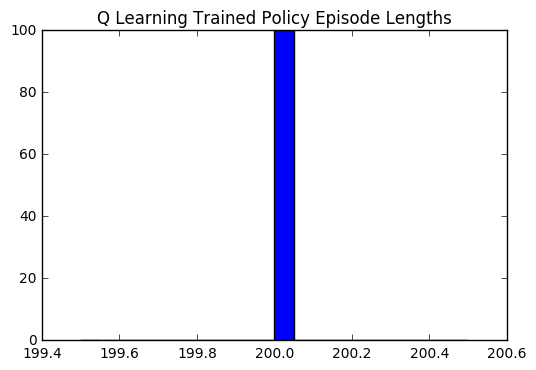

In [25]:
from reinforcement_learning import makeEpsilonGreedyPolicy

best_q_learning_dict = pickleLoad('best_Q_w_Q_learning')
Q = defaultdict(makeExploringDefaultDictFn(env), best_q_learning_dict)

policy = makeEpsilonGreedyPolicy(Q, 0, env.action_space.n)

returns, episode_lengths = tryPolicy(
    env, policy, observationToState, n_episodes=100, max_episode_len=300)
histogram(episode_lengths, "Q Learning Trained Policy Episode Lengths")